## Intro to fMRI Data Part III The General Linear Model

This is the Python Jupyter Notebook for the third Medium article about the organization and visualization of fMRI data.

First we start with importing the libraries for analysing and visualizing the dataset we downloaded and organized in the [first notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data.ipynb).

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

Next we load one of the .csv data files we created in the [first notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data.ipynb). After this we define the scan parameters as discussed in the [second notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data%20Part%20II%20Correlation%20Maps.ipynb), reshape the data to a format that we can work with and calculate the mean signal intensity for each voxel.

In [25]:
# Import the data for slice 36
data = np.genfromtxt('./fMRI_data/csv_data/slice_36.csv', delimiter=',')

# These are the main parameters of the fMRI scan and experimental desgin
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

x_size = 64
y_size = 64

# Reshape the data
data_ordered = data.reshape(x_size, y_size, acq_num)

# Calculate the mean signal for each voxel
mean_data = data_ordered.mean(axis=2)

Just like in the [previous notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data%20Part%20II%20Correlation%20Maps.ipynb) we will create a "design matrix" which represents our hypothesis of how the brain responds to the auditory stimulation.

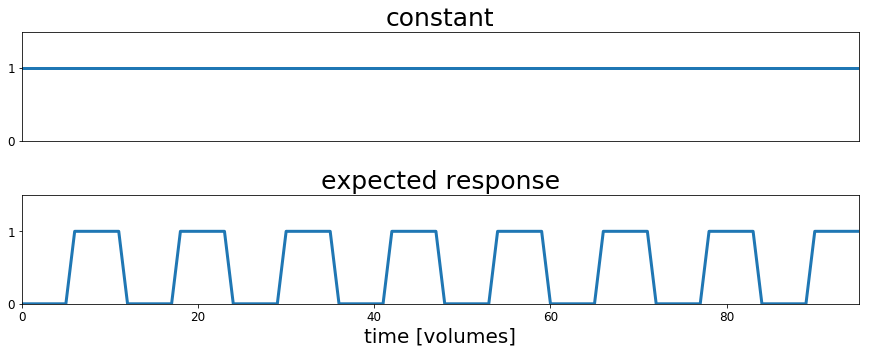

In [26]:
# Create the design matrix
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))

# Create the plots
fig, ax = plt.subplots(2,1, figsize=(15, 5))
ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xlabel('time [volumes]', fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

In the previous notebook we only used the second part of the design matrix for our correlation map but for the GLM analysis we need also the constant part. In the following we will implement the GLM as a function called do_GLM. The details about the GLM can be found in the corresponding medium article.

In [27]:
def do_GLM(X, y):
    
    # Make sure design matrix has the right orientation
    if X.shape[1] > X.shape[0]:
        X = X.transpose()
    
    # Calculate the dot product of the transposed design matrix and the design matrix
    # and invert the resulting matrix.
    tmp   = np.linalg.inv(X.transpose().dot(X))
    
    # Now calculate the dot product of the above result and the transposed design matrix
    tmp   = tmp.dot(X.transpose())

    # Pre-allocate variables
    beta  = np.zeros((y.shape[0], X.shape[1]))
    e     = np.zeros(y.shape)
    model = np.zeros(y.shape)
    r     = np.zeros(y.shape[0])
    
    # Find beta values for each voxel and calculate the model, error and the correlation coefficients 
    for i in range(y.shape[0]):
        beta[i]  = tmp.dot(y[i,:].transpose())
        model[i] = X.dot(beta[i])
        e[i]     = (y[i,:] - model[i])
        r[i]     = np.sqrt(model[i].var()/y[i,:].var())
    
    return beta, model, e, r

Now lets run this and create the maps as we did it for the correlation analysis.

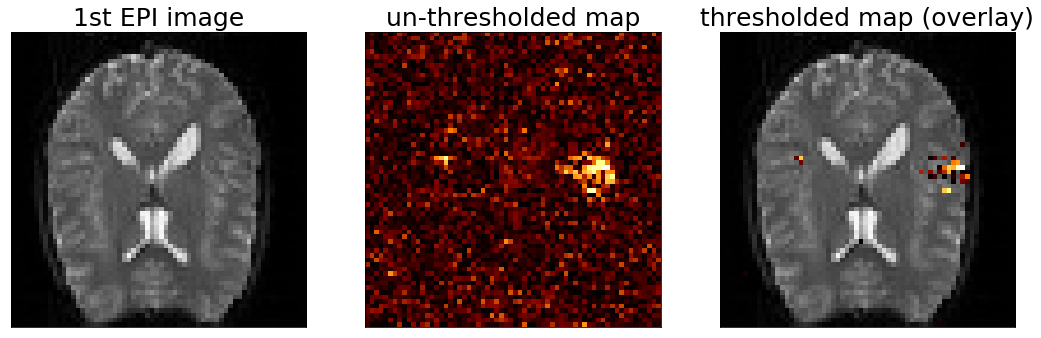

In [28]:
beta, model, e, r = do_GLM(design_matrix, data)

r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.35] = np.nan

fig, ax = plt.subplots(1,3,figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

Lets take the average response of all voxels above threshold from above as third regressor. Therefore we need to zscore the data and sclae it as follows.

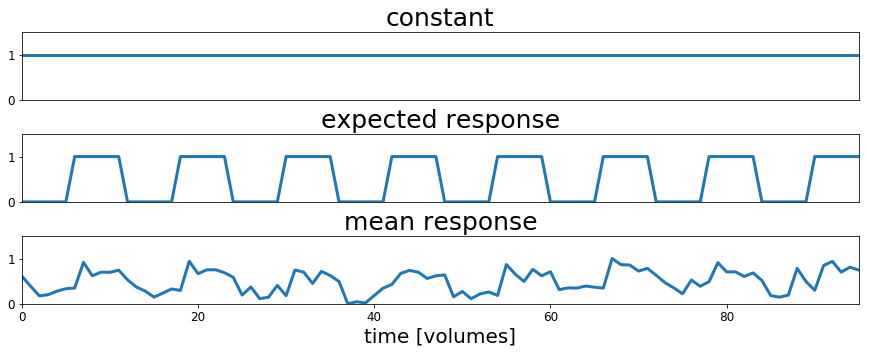

In [29]:
def scale(data):
    return (data - data.min()) / (data.max() - data.min())

def z_score(data):
    mean = data.mean(axis=1, keepdims=True)
    std = data.std(axis=1, keepdims=True)
    norm_data = (data-mean)/std
    return norm_data

avg = z_score(data_ordered[~np.isnan(map),:])
avg = np.transpose(avg).mean(axis=1)
avg = scale(avg)

design_matrix = np.array((constant, predicted_response, avg))


# Create the plots
fig, ax = plt.subplots(3,1, figsize=(15, 5))
ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xticks([])
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

ax[2].plot(design_matrix[2], lw=3)
ax[2].set_xlim(0, acq_num-1)
ax[2].set_ylim(0, 1.5)
ax[2].set_title('mean response', fontsize=25)
ax[2].set_yticks([0,1])
ax[2].set_xlabel('time [volumes]', fontsize=20)
ax[2].tick_params(labelsize=12)
ax[2].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Here we visualize the mean response again

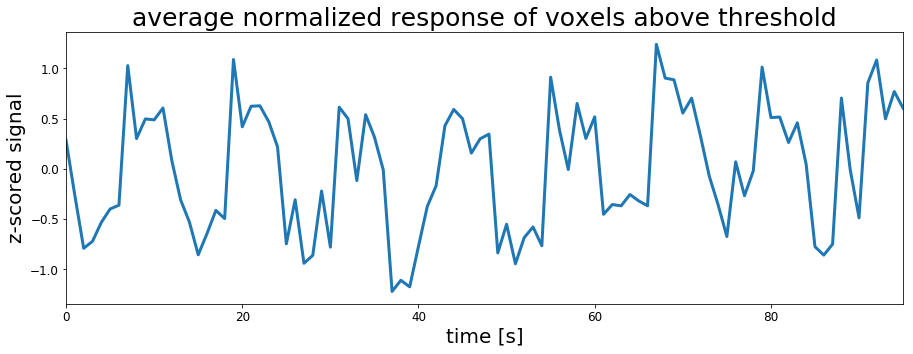

In [30]:
avg = z_score(data_ordered[~np.isnan(map),:])

# and plot the result
fig, ax = plt.subplots(1,1,figsize=(15, 5))

ax.plot(np.transpose(avg).mean(axis=1), lw=3)
ax.set_title('average normalized response of voxels above threshold', fontsize=25)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('z-scored signal', fontsize=20)
ax.tick_params(labelsize=12)

plt.show()

Lets construct the Gaussian kernel and the 2D convolution funtion.

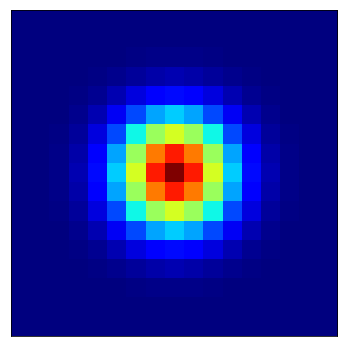

In [31]:
# TAKEN FROM: http://subsurfwiki.org/wiki/Gaussian_filter

import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(8)

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(gaussian_kernel_array, cmap='jet', interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [32]:
# Adapted from: http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html

def conv_image(image, input_kernel):
    # Flip the kernel
    kernel = np.flipud(np.fliplr(input_kernel))    
    
    # Create output array
    output = np.zeros_like(image)            
    
    # Determine size parameters
    m, n = kernel.shape[0]-1, kernel.shape[1]-1
    M, N = int((m/2)), int((n/2))
    
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + m, image.shape[1] + n))   
    image_padded[M:-M, N:-N] = image
    
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            
            output[y,x]=(kernel*image_padded[y:y +m+1, x:x +n+1]).sum() 
            #output[y,x]=(kernel*image_padded[y:y +m+1, x:x +n+1]).mean() 
    return output

plot the raw EPI image, the kernel and the smoothed picture

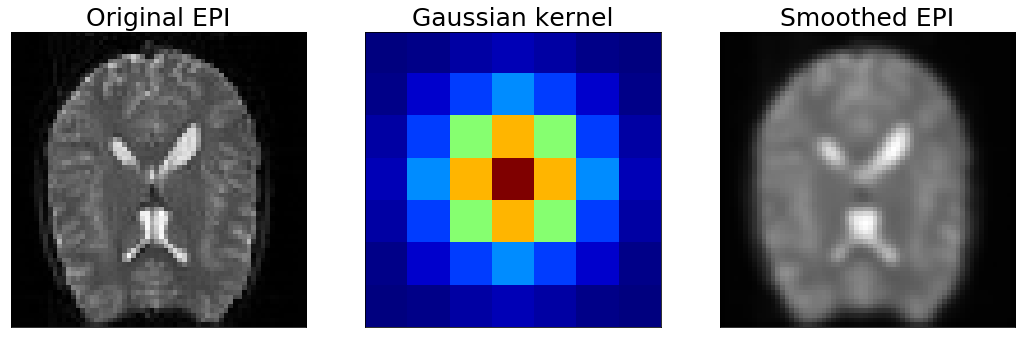

In [33]:
gaussian_kernel_array = gaussian_kernel(3)
smoothed_mean_data = conv_image(mean_data, gaussian_kernel_array)


#plt.imshow(smoothed_mean_data, cmap='gray')

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('Original EPI', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(gaussian_kernel_array, cmap='jet', interpolation='nearest')
ax[1].set_title('Gaussian kernel', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(smoothed_mean_data, cmap='gray')
ax[2].set_title('Smoothed EPI', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

Create the GLM on the smoothed data

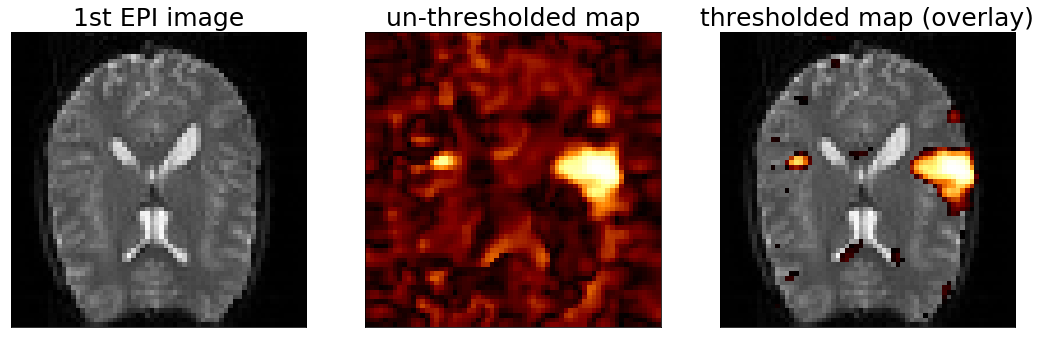

In [34]:
gaussian_kernel_array = gaussian_kernel(3)

data_smoothed = np.zeros_like(data_ordered)
for i in range(data_ordered.shape[2]):
    data_smoothed[:,:,i] = conv_image(data_ordered[:,:,i], gaussian_kernel_array)
    
data_smoothed = data_smoothed.reshape(x_size * y_size, acq_num)
beta, model, e, r = do_GLM(design_matrix, data_smoothed)

r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.35] = np.nan

fig, ax = plt.subplots(1,3,figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

Finaly lets calculate and plot the maos for multiple slices...

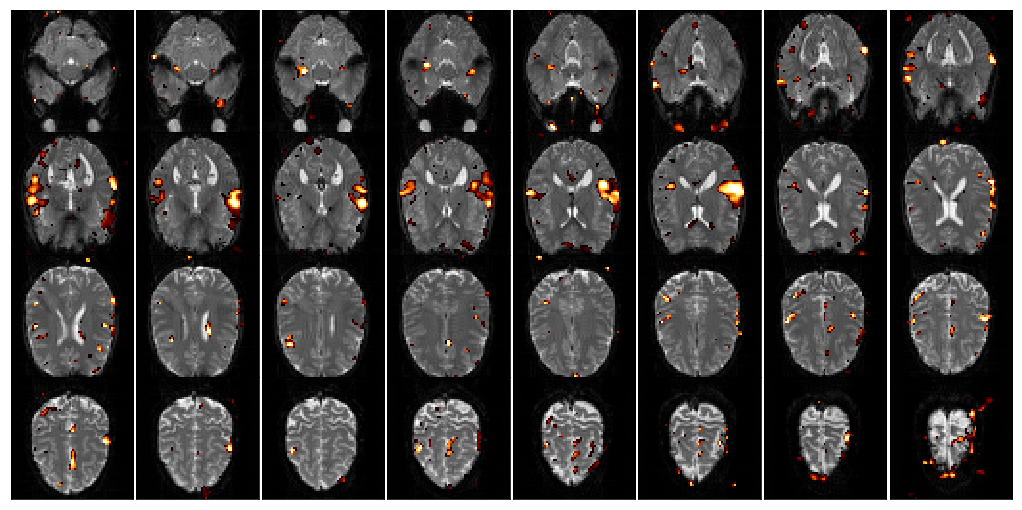

In [347]:
files = os.listdir('.\data')

n=0
m=0
fig, ax = plt.subplots(4, 8,figsize=(18, 9))
for i in files[23:55]:
    data = np.genfromtxt('data\{}'.format(i), delimiter=',')
    data_ordered = data.reshape(x_size,y_size,acq_num)
    mean_data = data_ordered.mean(axis=2)
    
    gaussian_kernel_array = gaussian_kernel(3)

    data_smoothed = np.zeros_like(data_ordered)
    for i in range(data_ordered.shape[2]):
        data_smoothed[:,:,i] = conv_image(data_ordered[:,:,i], gaussian_kernel_array)

    data_smoothed = data_smoothed.reshape(x_size * y_size, acq_num)
    beta, model, e, r = do_GLM(design_matrix, data_smoothed)
    
    r = r.reshape(x_size,y_size)
    map = r.copy()
    map[map<0.35] = np.nan

    #ax[n].set_title('Thresholded GLM activation map overlay')
    ax[n][m].set_xticks([])
    ax[n][m].set_yticks([])
    ax[n][m].imshow(mean_data, cmap='gray')
    ax[n][m].imshow(map, cmap='afmhot')
    
    if m==7:
        n +=1
        m = 0
    else:
        m +=1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()